## Chuẩn bị dữ liệu

In [1]:
# %pip install kagglehub

In [1]:
import os
import torch
import kagglehub
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from PIL import Image
from tqdm import tqdm
from torch import Tensor
from typing import Optional
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.modules.transformer import _get_activation_fn

In [2]:
# Download latest version
path = kagglehub.dataset_download("meherunnesashraboni/multi-label-image-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Dell\.cache\kagglehub\datasets\meherunnesashraboni\multi-label-image-classification-dataset\versions\7


In [3]:
# Load the CSV file containing image paths and labels
data = pd.read_csv(path + '/multilabel_modified/multilabel_classification(6)-reduced_modified.csv')
columns_names = data.columns
data.rename(columns={columns_names[1]:'Classes'}, inplace=True)

print(data.head())

   Image_Name   Classes  motorcycle  truck  boat  bus  cycle  sitar  ektara  \
0  image1.jpg      bus            0      0     0    1      0      0       0   
1  image2.jpg     sitar           0      0     0    0      0      1       0   
2  image3.jpg    flutes           0      0     0    0      0      0       0   
3  image4.jpg      bus            0      0     0    1      0      0       0   
4  image5.jpg       bus           0      0     0    1      0      0       0   

   flutes  tabla  harmonium  
0       0      0          0  
1       0      0          0  
2       1      0          0  
3       0      0          0  
4       0      0          0  


In [4]:
# Example structure: 'image_name', 'labels'
# Split the data into train and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [5]:
# Define the path to the images folder
image_dir = path + '/multilabel_modified/images'

# Helper function to load an image and its labels
def load_image_and_labels(row):
    image_path = os.path.join(image_dir, row['Image_Name'])
    image = Image.open(image_path).convert('RGB')
    labels = row.iloc[-10:].tolist()
    return image, labels

# Load and display an example image and its labels
example_image, example_labels = load_image_and_labels(train_data.iloc[0])
print(f'Labels: {example_labels}')

Labels: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Custom dataset class
class MultiLabelDataset(Dataset):
    def __init__(self, data, image_dir, transform=None):
        self.data = data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image, labels = load_image_and_labels(row)
        if self.transform:
            image = self.transform(image)
        label_tensor = torch.tensor([int(lbl) for lbl in labels], dtype=torch.float)
        return image, label_tensor

# Create DataLoader
train_dataset = MultiLabelDataset(train_data, image_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Check an example batch
images, labels = next(iter(train_loader))
print(f'Image batch shape: {images.shape}')
print(f'Label batch shape: {labels.shape}')

Image batch shape: torch.Size([1, 3, 128, 128])
Label batch shape: torch.Size([1, 10])


In [8]:
target_classes = data.columns[2:]
input_dim = 3 * 128 * 128  # 3 kênh màu, kích thước ảnh 128x128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def show_image_with_labels(image, predicted_labels, actual_labels):
    image_np = image.permute(1, 2, 0).numpy()

    # Normalize to [0, 1] range for display
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    # Create a subplot for displaying the image and labels
    plt.imshow(image_np)
    plt.axis('off')
    
    # Get top 3 predicted labels
    _, predicted_indices = torch.topk(predicted_labels, 3)

    # Create strings for predicted and actual labels
    pred_str = "Predicted: " + ", ".join([target_classes[i] for i in predicted_indices.tolist()])
    actual_str = "Actual: " + ", ".join([target_classes[i] for i in range(len(target_classes)) if actual_labels[i] == 1])
    
    # Display the labels
    plt.title(f"{pred_str}\n{actual_str}", fontsize=12)
    plt.show()

## Example of using Transformer in Multi Label Classification

In [8]:
# Source: https://github.com/Alibaba-MIIL/ML_Decoder/blob/main/src_files/ml_decoder/ml_decoder.py
class GroupFC(object):
    def __init__(self, embed_len_decoder: int):
        self.embed_len_decoder = embed_len_decoder

    def __call__(
        self, h: torch.Tensor, duplicate_pooling: torch.Tensor, out_extrap: torch.Tensor
    ):
        for i in range(h.shape[1]):
            h_i = h[:, i, :]
            if len(duplicate_pooling.shape) == 3:
                w_i = duplicate_pooling[i, :, :]
            else:
                w_i = duplicate_pooling
            out_extrap[:, i, :] = torch.matmul(h_i, w_i)


class MLDecoder(nn.Module):
    def __init__(
        self,
        num_classes,
        num_of_groups=-1,
        decoder_embedding=768,
        initial_num_features=2048,
        zsl=0,
    ):
        super(MLDecoder, self).__init__()
        embed_len_decoder = 100 if num_of_groups < 0 else num_of_groups
        if embed_len_decoder > num_classes:
            embed_len_decoder = num_classes

        # switching to 768 initial embeddings
        decoder_embedding = 768 if decoder_embedding < 0 else decoder_embedding
        embed_standart = nn.Linear(initial_num_features, decoder_embedding)

        # non-learnable queries
        if not zsl:
            query_embed = nn.Embedding(embed_len_decoder, decoder_embedding)
            query_embed.requires_grad_(False)
        else:
            query_embed = None

        # decoder
        decoder_dropout = 0.1
        num_layers_decoder = 1
        dim_feedforward = 2048
        layer_decode = nn.TransformerDecoderLayer(
            d_model=decoder_embedding, 
            nhead=8, 
            dim_feedforward=dim_feedforward, 
            dropout=decoder_dropout
        )
        self.decoder = nn.TransformerDecoder(
            layer_decode, num_layers=num_layers_decoder
        )
        self.decoder.embed_standart = embed_standart
        self.decoder.query_embed = query_embed
        self.zsl = zsl

        if self.zsl:
            if decoder_embedding != 300:
                self.wordvec_proj = nn.Linear(300, decoder_embedding)
            else:
                self.wordvec_proj = nn.Identity()
            self.decoder.duplicate_pooling = torch.nn.Parameter(
                torch.Tensor(decoder_embedding, 1)
            )
            self.decoder.duplicate_pooling_bias = torch.nn.Parameter(torch.Tensor(1))
            self.decoder.duplicate_factor = 1
        else:
            # group fully-connected
            self.decoder.num_classes = num_classes
            self.decoder.duplicate_factor = int(num_classes / embed_len_decoder + 0.999)
            self.decoder.duplicate_pooling = torch.nn.Parameter(
                torch.Tensor(
                    embed_len_decoder, decoder_embedding, self.decoder.duplicate_factor
                )
            )
            self.decoder.duplicate_pooling_bias = torch.nn.Parameter(
                torch.Tensor(num_classes)
            )
        torch.nn.init.xavier_normal_(self.decoder.duplicate_pooling)
        torch.nn.init.constant_(self.decoder.duplicate_pooling_bias, 0)
        self.decoder.group_fc = GroupFC(embed_len_decoder)
        self.train_wordvecs = None
        self.test_wordvecs = None

    def forward(self, x):
        if len(x.shape) == 4:  # [bs,2048, 7,7]
            embedding_spatial = x.flatten(2).transpose(1, 2)
        else:  # [bs, 197,468]
            embedding_spatial = x
        
        embedding_spatial_786 = self.decoder.embed_standart(embedding_spatial)
        embedding_spatial_786 = torch.nn.functional.relu(
            embedding_spatial_786, inplace=True
        )

        bs = embedding_spatial_786.shape[0]
        if self.zsl:
            query_embed = torch.nn.functional.relu(
                self.wordvec_proj(self.decoder.query_embed)
            )
        else:
            query_embed = self.decoder.query_embed.weight
        tgt = query_embed.unsqueeze(1).expand(
            -1, bs, -1
        )  # no allocation of memory with expand
        h = self.decoder(
            tgt, embedding_spatial_786.unsqueeze(0).transpose(0, 1)
        )  # [embed_len_decoder, batch, 768]
        h = h.transpose(0, 1)

        out_extrap = torch.zeros(
            h.shape[0],
            h.shape[1],
            self.decoder.duplicate_factor,
            device=h.device,
            dtype=h.dtype,
        )
        self.decoder.group_fc(h, self.decoder.duplicate_pooling, out_extrap)
        if not self.zsl:
            h_out = out_extrap.flatten(1)[:, : self.decoder.num_classes]
        else:
            h_out = out_extrap.flatten(1)
        h_out += self.decoder.duplicate_pooling_bias
        logits = h_out
        return logits

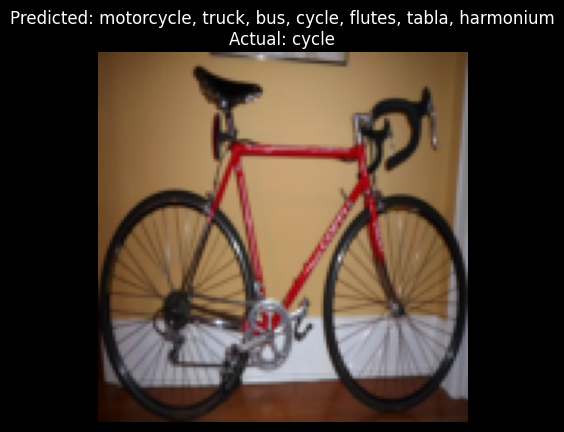

Predicted labels: [1, 1, 0, 1, 1, 0, 0, 1, 1, 1]
Actual labels:    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [10]:
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT) # Backbone model
ml_decoder_head = MLDecoder(num_classes=10, initial_num_features=1000)

# Inference and visualization loop
with torch.no_grad():
    for images, labels in train_loader:
        features = resnet50(images)  # Extract features using ResNet-50
        logits = ml_decoder_head(features)  # Get logits from ML-Decoder head

        # Convert logits to binary predictions using a threshold (e.g., 0.5)
        predictions = (torch.sigmoid(logits) > 0.5).int()

        # Visualize the first image and its labels
        show_image_with_labels(images[0], predictions[0], labels[0])
        print("Predicted labels:", predictions[0].tolist())
        print("Actual labels:   ", [int(lbl) for lbl in labels[0].tolist()])
        break  # Only show the first batch for now

## C2AE for Multi Label Classification

In [15]:
# Ref: https://github.com/ssmele/C2AEinTorch/blob/master/C2AE.py
# Ref: https://github.com/ssmele/C2AEinTorch/blob/master/Mele_StructPred_FinalProj.pdf

class Fd(torch.nn.Module):
    def __init__(self, in_dim=16, H=256, out_dim=10, fin_act=None):
        super(Fd, self).__init__()
        self.fc1 = torch.nn.Linear(in_dim, H)
        self.fc2 = torch.nn.Linear(H, out_dim)
        self.fin_act = fin_act

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return self.fin_act(x) if self.fin_act else x


class Fx(torch.nn.Module):
    def __init__(self, in_dim, H1=512, H2=256, out_dim=16):
        super(Fx, self).__init__()
        self.fc1 = torch.nn.Linear(in_dim, H1)
        self.fc2 = torch.nn.Linear(H1, H2)
        self.fc3 = torch.nn.Linear(H2, out_dim)
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x


class Fe(torch.nn.Module):

    def __init__(self, in_dim=10, H=512, out_dim=16):
        super(Fe, self).__init__()
        self.fc1 = torch.nn.Linear(in_dim, H)
        self.fc2 = torch.nn.Linear(H, out_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x


class C2AE(torch.nn.Module):

    def __init__(self, Fx, Fe, Fd, beta=1, alpha=.5, emb_lambda=.5, latent_dim=6,
                 device=None):
        super(C2AE, self).__init__()
        # Define main network components.
        # Encodes x into latent space. X ~ z
        self.Fx = Fx
        # Encodes y into latent space. Y ~ z
        self.Fe = Fe
        # Decodes latent space into Y. z ~ Y
        self.Fd = Fd

        # Hyperparam used to set tradeoff between latent loss, and corr loss.
        self.alpha = alpha
        self.beta = beta
        # Lagrange to use in embedding loss.
        self.emb_lambda = emb_lambda
        self.latent_I = torch.eye(latent_dim).to(device)

    def forward(self, x, y=None):
        """
        Forward pass of C2AE model.

        Training:
            Runs feature vector x through Fx, then encodes y through Fe and
            computes latent loss (MSE between feature maps). Then z = Fe(y) is
            sent through decoder network in which it tries to satisfy
            correlation equation.

        Testing:
            Simply runs feature vector x through autoencoder. Fd(Fx(x))
            This will result in a logits vec of multilabel preds.
        """
        if self.training:
            # Calculate feature, and label latent representations.
            fx_x = self.Fx(x)
            fe_y = self.Fe(y)
            # Calculate decoded latent representation.
            fd_z = self.Fd(fe_y)
            return fx_x, fe_y, fd_z
        else:
            # If evaluating just send through encoder and decoder.
            return self.predict(x)

    def _predict(self, y):
        """This method predicts with the y encoded latent space.
        """
        return self.Fd(self.Fe(y))

    def predict(self, x):
        """This method predicts with the x encoded latent space.
        """
        return self.Fd(self.Fx(x))

    def corr_loss(self, preds, y):
        """This method compares the predicted probabilitie class distribution
        from the decoder, with the true y labels.
        
        How to vectorize this computation was inspired from this implementation:
        https://github.com/hinanmu/C2AE_tensorflow/blob/master/src/network.py
        """
        # Generate masks for [0,1] elements.
        ones = (y == 1)
        zeros = (y == 0)
        # Use broadcasting to apply logical and between mask arrays.
        # This will only indicate locations where both masks are 1.
        # THis corresponds to set we are enumerating in eq (3) in Yah et al.
        ix_matrix = ones[:, :, None] & zeros[:, None, :]
        # Use same broadcasting logic to generate exponetial differences.
        # This like the above broadcast will do so between all pairs of points
        # for every datapoint.
        diff_matrix = torch.exp(-(preds[:, :, None] - preds[:, None, :]))
        # This will sum all contributes to loss for each datapoint.
        losses = torch.flatten(diff_matrix*ix_matrix, start_dim=1).sum(dim=1)
        # Normalize each loss add small epsilon incase 0.
        losses /= (ones.sum(dim=1)*zeros.sum(dim=1) + 1e-4)
        # Replace inf, and nans with 0.
        losses[losses == float('Inf')] = 0
        losses[torch.isnan(losses)] = 0
        # Combine all losses to retrieve final loss.
        return losses.sum()

    def latent_loss(self, fx_x, fe_y):
        """
        Loss between latent space generated from fx, and fe.

        ||Fx(x) - Fe(y)||^2 s.t. FxFx^2 = FyFy^2 = I

        This is seen in equation (2), and implemention details seen in 
        decomposed version of loss.

        First version contains decomposition of loss function, making use of 
        lagrange multiplier to account for constraint.

        Second version just calculates the mean squared error.
        """
        # ********** Version 1: Implemented as suggested in Yeh et al. # **********
        # Initial condition.
        c1 = fx_x - fe_y
        # Here to help hold constraint of FxFx^2 = FyFy^2 = I.
        c2 = fx_x.T@fx_x - self.latent_I
        c3 = fe_y.T@fe_y - self.latent_I
        # Combine loss components as specified in Yah et al.
        latent_loss = torch.trace(
            c1@c1.T) + self.emb_lambda*torch.trace(c2@c2.T + c3@c3.T)
        # ********** Version 2: Ignore constraint **********
        #latent_loss = torch.mean((fx_x - fe_y)**2)
        return latent_loss

    def losses(self, fx_x, fe_y, fd_z, y):
        """This method calculates the main loss functions required
        when composing the loss function.
        """
        l_loss = self.latent_loss(fx_x, fe_y)
        c_loss = self.corr_loss(fd_z, y)
        return l_loss, c_loss

In [ ]:
model = C2AE(Fx(input_dim, 512, 256, 16), Fe(10, 512, 16), Fd(16, 256, 10), latent_dim=16, device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

model.train()
for epoch in range(10):
    epoch_loss = 0
    for images, labels in tqdm(train_loader):
        # Convert images and labels to 1D tensors
        images = images.to(device).view(images.size(0), -1)
        labels = labels.to(device)

        # Forward pass
        fx_x, fe_y, fd_z = model(images, labels)
        
        # Calculate losses from latent space and correlation
        latent_loss, corr_loss = model.losses(fx_x, fe_y, fd_z, labels)
        latent_loss /= images.size(0)
        corr_loss /= images.size(0)
        
        # Combine losses with fixed alpha and beta weights
        loss = model.beta * latent_loss + model.alpha * corr_loss

        # Backward pass and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{10}], Loss: {epoch_loss / len(train_loader):.4f}')

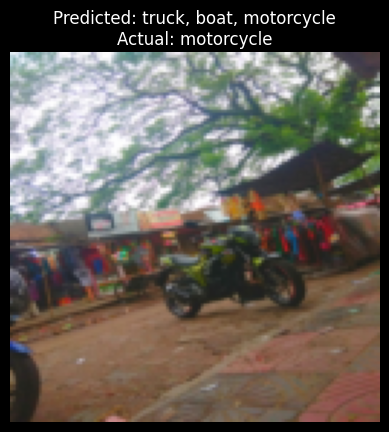

Predicted labels: [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Actual labels:    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
# Inference and visualization loop
with torch.no_grad():
    model.eval() 
    for images, labels in train_loader:
        images_original = images.clone()

        images = images[0].to(device).view(images.size(0), -1)

        predicted_labels = model(images)
        
        logits = torch.round(torch.sigmoid(predicted_labels))
        
        predictions = (torch.sigmoid(logits) > 0.6).int()
        
        show_image_with_labels(images_original[0], predictions[0].cpu(), labels[0])

        print("Predicted labels:", [int(lbl) for lbl in predictions[0].tolist()])
        print("Actual labels:   ", [int(lbl) for lbl in labels[0].tolist()])

        break  # Chỉ hiển thị một batch